In [1]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
import numpy as np
from umap import UMAP

from flash_ansr import FlashANSR, GenerationConfig, get_path, FlashANSRDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = "ansr-models/v21.0-160M"

In [3]:
nsr = FlashANSR.load(
    directory=get_path('models', MODEL),
    # generation_config=GenerationConfig(method='beam_search', beam_width=128 * 16, equivalence_pruning=True),
    generation_config=GenerationConfig(method='softmax_sampling', choices=1024 * 32),
    parsimony=0.05
).to(device)

In [4]:
# dataset = FlashANSRDataset.from_config(get_path('configs', MODEL.split('/')[-1], 'dataset_val.yaml'))

In [5]:
dataset = FlashANSRDataset.from_config(get_path('data', 'ansr-data', 'test_set', 'feynman', 'dataset.yaml'))

Compiling Skeletons: 100%|██████████| 89/89 [00:00<00:00, 22933.78it/s]


In [6]:
N_TEST = 128
batch_size = 128

In [7]:
labels = []
embeddings = []

with torch.no_grad():
    for b, batch in enumerate(dataset.iterate(steps=N_TEST, batch_size=batch_size, n_per_equation=32, verbose=True, persistent=True, tokenizer_oov='unk')):
        batch = dataset.collate(batch, device)
        data_tensor = torch.cat([batch['x_tensors'], batch['y_tensors']], dim=-1)

        outputs = nsr.flash_ansr_transformer._create_memory(data_tensor)

        embeddings.extend(outputs.cpu().numpy())

        labels.extend(batch['skeleton_hash'])

Generating Batches: 100%|██████████| 128/128 [00:24<00:00,  5.24it/s]


In [8]:
embeddings = np.array(embeddings).reshape(len(embeddings), -1)
embeddings.shape

(16384, 49152)

In [9]:
label_to_idx = {label: idx for idx, label in enumerate(set(labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

In [10]:
umap = UMAP(n_components=2, verbose=True, n_neighbors=64, metric='cosine', min_dist=0.5).fit(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.5, n_neighbors=64, verbose=True)
Wed Oct 22 18:22:07 2025 Construct fuzzy simplicial set
Wed Oct 22 18:22:08 2025 Finding Nearest Neighbors
Wed Oct 22 18:22:09 2025 Building RP forest with 11 trees
Wed Oct 22 18:22:20 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Wed Oct 22 18:27:54 2025 Finished Nearest Neighbor Search
Wed Oct 22 18:27:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Oct 22 18:28:00 2025 Finished embedding


In [11]:
from scipy.spatial import ConvexHull
import simplipy as sp

engine = sp.SimpliPyEngine.load('dev_7-3')

In [28]:
show_idx = np.arange(10) + 40

[]

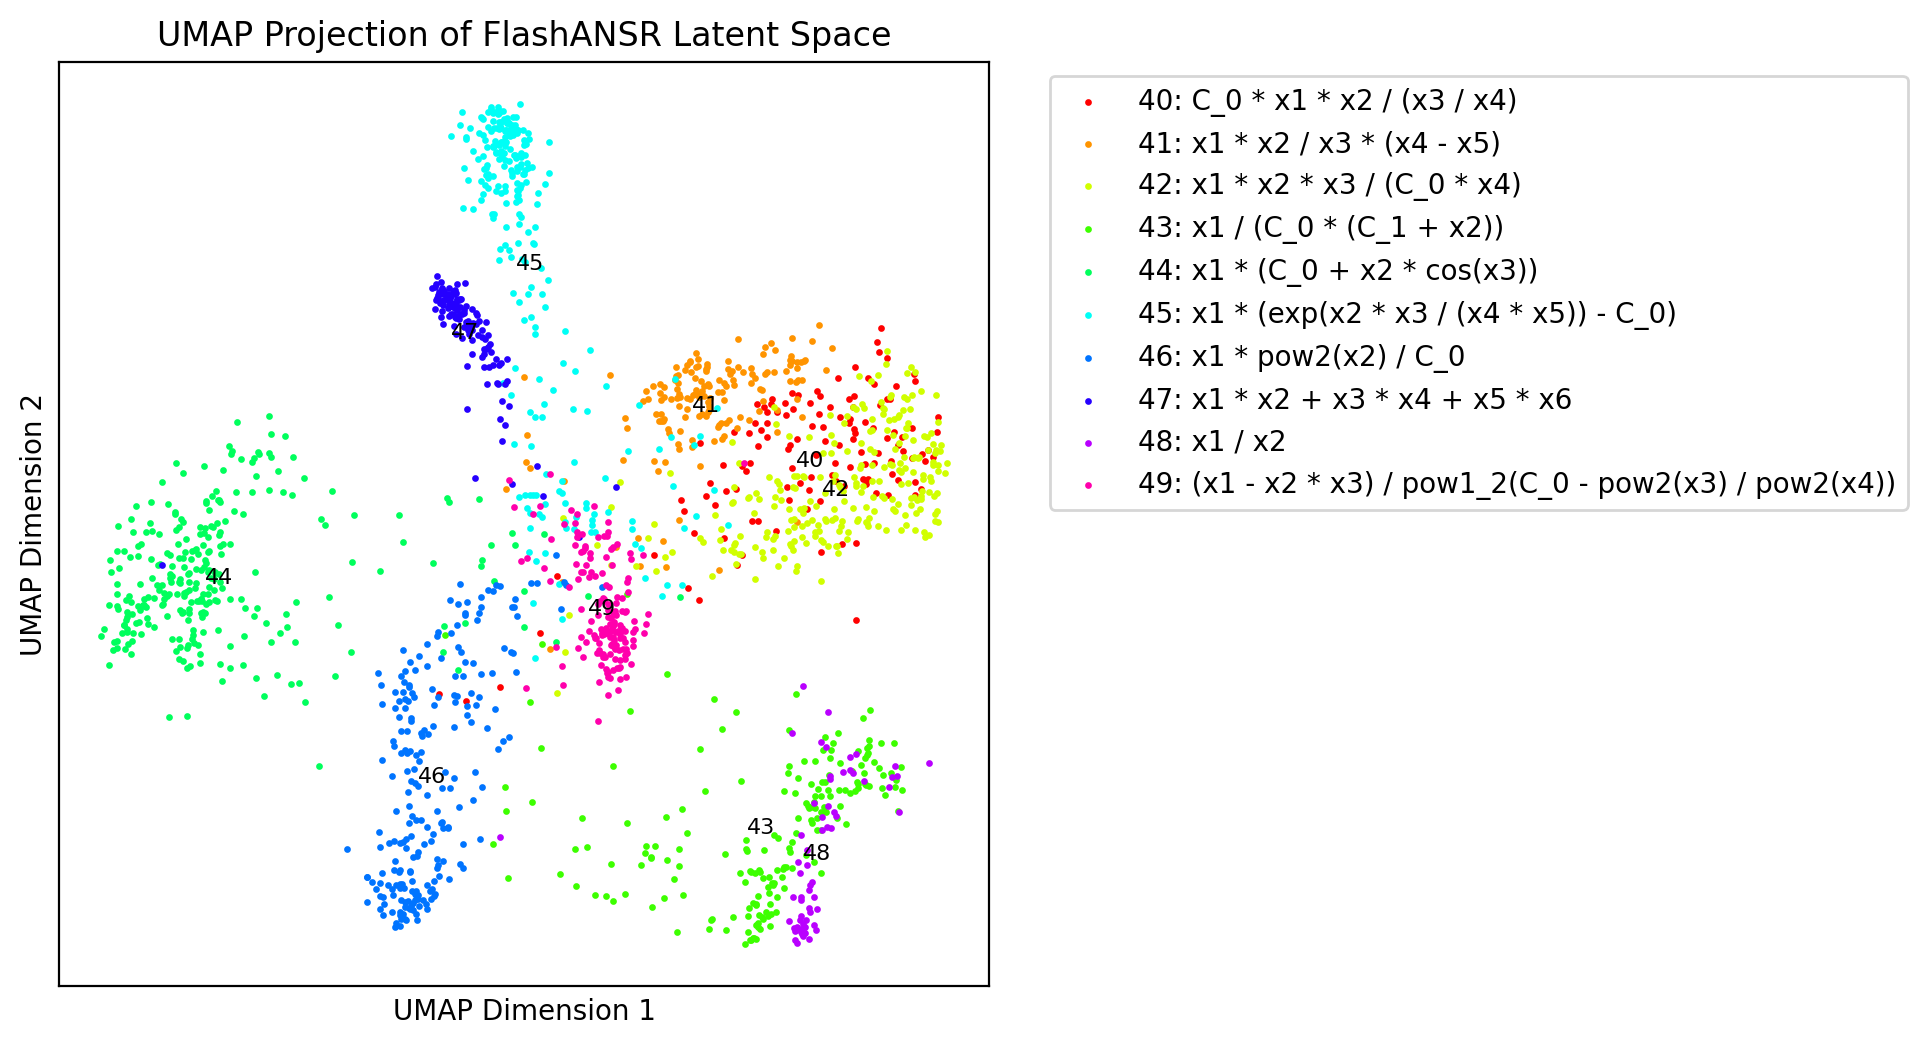

In [29]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

def cmap(n, total):
    return plt.get_cmap('hsv')(n / total)

for i, idx in enumerate(show_idx):
    label = idx_to_label[idx]
    mask = np.array([l == label for l in labels])
    points = umap.embedding_[mask]
    ax.scatter(points[:, 0], points[:, 1], alpha=1, s=2, color=cmap(i, len(show_idx)), label=f"{idx}: {engine.prefix_to_infix(sp.utils.explicit_constant_placeholders(list(label))[0])}")
    # ax.grid(alpha=0.5)

    centroid = points.mean(axis=0)
    ax.text(centroid[0], centroid[1], idx, fontsize=8, ha='center', va='center')

    # # Draw the convex hull around the points
    # if len(points) >= 3:
    #     hull = ConvexHull(points)
    #     hull_points = points[hull.vertices]
    #     ax.fill(hull_points[:, 0], hull_points[:, 1], alpha=0.05, color=cmap(i, len(show_idx)))

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title('UMAP Projection of FlashANSR Latent Space')
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_xticks([])
ax.set_yticks([])

# scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=np.arange(len(embeddings_2d)), cmap='tab20', alpha=0.7)